In [1]:
import numpy as np
import scipy.io as sio
import scipy.linalg as slinalg
from skimage.transform import resize
from scipy.ndimage.filters import gaussian_filter1d as gf1d
import matplotlib.pyplot as plt
%matplotlib notebook
import sys
sys.path.append("../")
import ICP
import importlib
from PDE2D import *
from Mahalanobis import *
from SyntheticExamples import FlatTorusIdeal
from Kuramoto import *
from Mahalanobis import *
from LocalPCA import *
from ripser import ripser
from persim import plot_diagrams as plot_dgms

In [2]:
np.random.seed(0)

theta1 = np.pi/3
theta2 = 0
fac = 0.5
Win = 80
pd1 = (80, 1)
pd2 = (45, 45)
N = 5500
cropheight = 250 #195


delta = 2
n_points = 100
rank = 2
pca_dim = 120
maxeigs = 90
dMaxSqr = 1000


ks1 = KSSimulation(co_rotating=False, scale=(fac*7, fac/2), reldir='../')
ks1.crop(0, cropheight, 0, ks1.I.shape[1])
ks1.makeObservations(pd1, N)
ks1.thetas[0:N] = theta1
ks1.completeObservations()
ks1.resort_byraster()

ks2 = KSSimulation(co_rotating=False, scale=(fac*7, fac/2), reldir='../')
ks2.crop(0, cropheight, 0, ks2.I.shape[1])
ks2.makeObservations(pd2, N)
ks2.thetas[0:N] = theta2
ks2.completeObservations()
ks2.resort_byraster()

pdes = [ks1, ks2]
for ks in pdes:
    if pca_dim < ks.patches.shape[1]:
        ks.compose_with_dimreduction(dim=pca_dim)

Making 5500 observations of dimension (80, 1) on a grid of (250, 100)...
Elapsed time patch sampling: 0.115
Elapsed time patch sampling: 0.107
Making 5500 observations of dimension (45, 45) on a grid of (250, 100)...
Elapsed time patch sampling: 2.74
Elapsed time patch sampling: 2.65
Reducing patch dimensions from 2025 to 120


(5500, 80)
Computing Jacobians, rank = 2, maxiegs = 80...
0 of 5500
100 of 5500
200 of 5500
300 of 5500
400 of 5500
500 of 5500
600 of 5500
700 of 5500
800 of 5500
900 of 5500
1000 of 5500
1100 of 5500
1200 of 5500
1300 of 5500
1400 of 5500
1500 of 5500
1600 of 5500
1700 of 5500
1800 of 5500
1900 of 5500
2000 of 5500
2100 of 5500
2200 of 5500
2300 of 5500
2400 of 5500
2500 of 5500
2600 of 5500
2700 of 5500
2800 of 5500
2900 of 5500
3000 of 5500
3100 of 5500
3200 of 5500
3300 of 5500
3400 of 5500
3500 of 5500
3600 of 5500
3700 of 5500
3800 of 5500
3900 of 5500
4000 of 5500
4100 of 5500
4200 of 5500
4300 of 5500
4400 of 5500
4500 of 5500
4600 of 5500
4700 of 5500
4800 of 5500
4900 of 5500
5000 of 5500
5100 of 5500
5200 of 5500
5300 of 5500
5400 of 5500
Elapsed Time: 14
Computing Mahalanobis Distances...
Elapsed Time: 111
2.677018961209109
Building diffusion map matrix...
Elapsed Time: 0.615
Solving eigen system (sparsity 0.0133)...
Elapsed Time: 0.128
(5500, 120)
Computing Jacobians, ran

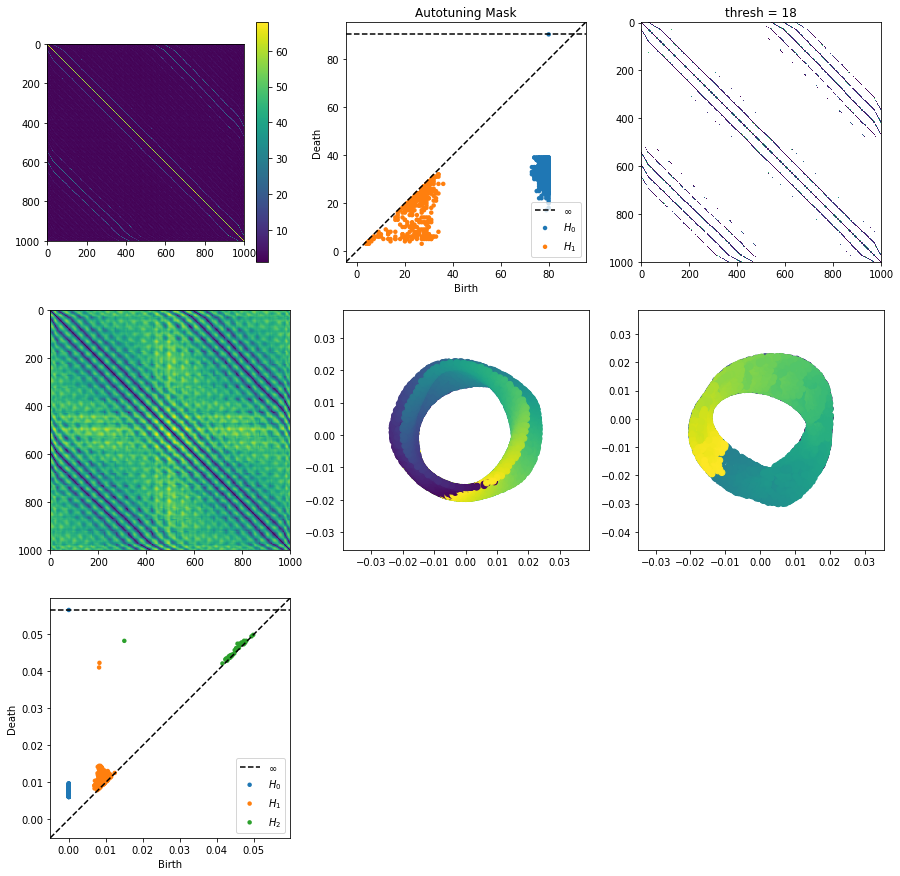

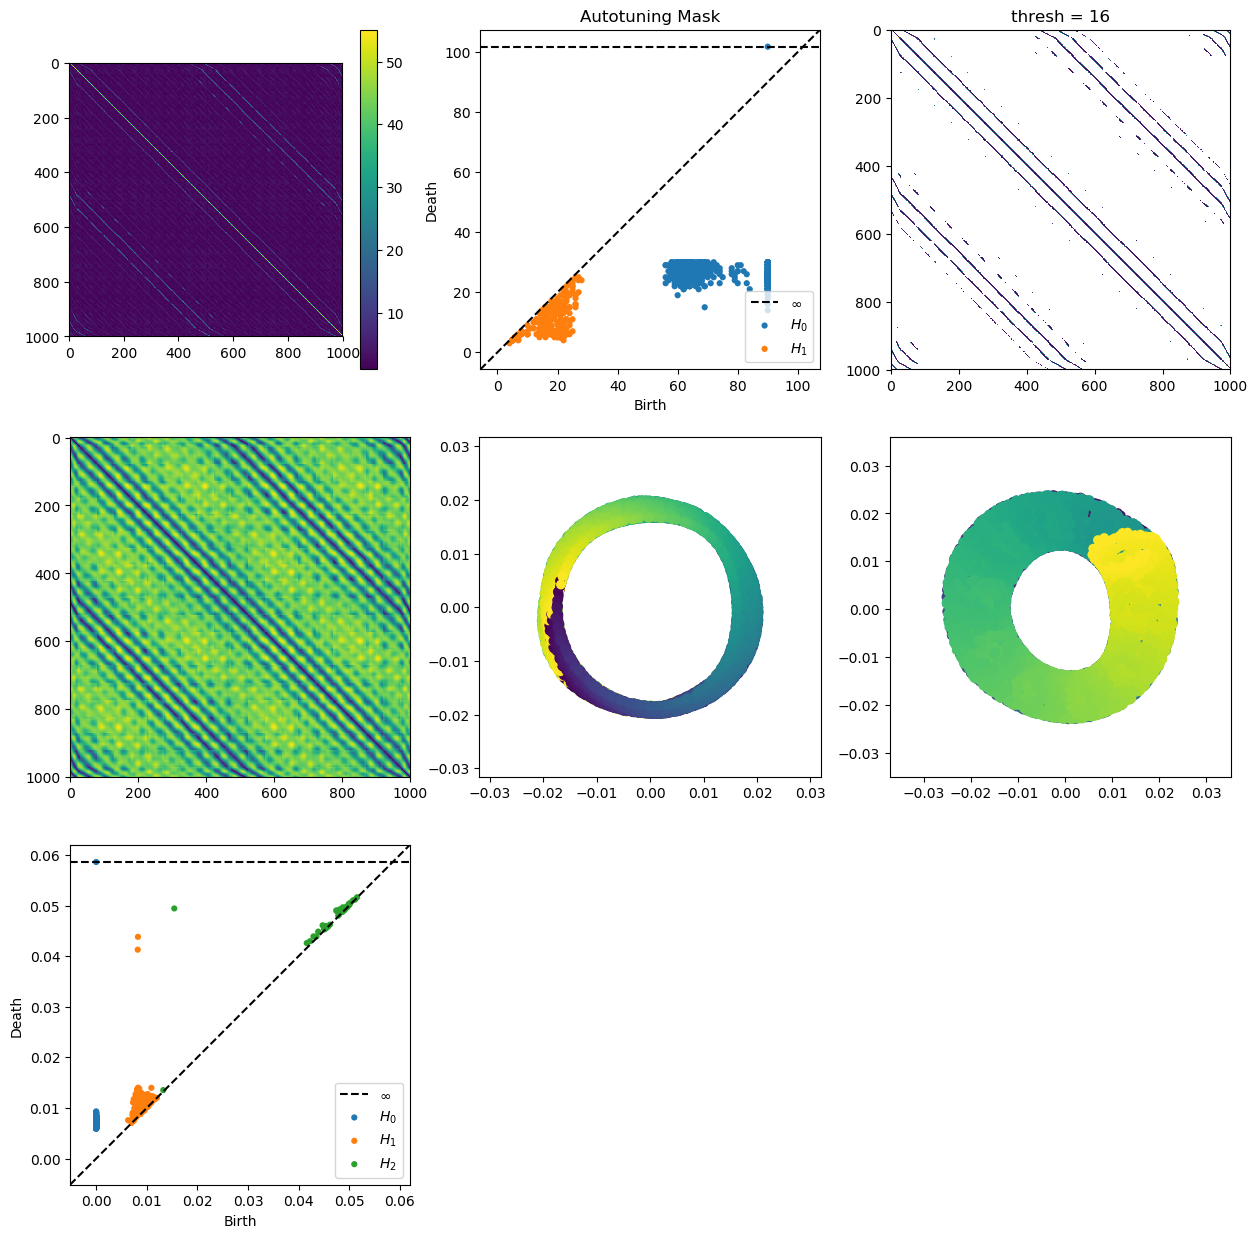

In [3]:
## Perform diffusion maps on each set individually
Ys = []
alldgms = []
for i in range(2):
    ksi = pdes[i]
    print(ksi.patches.shape)
    
    ## Step 1: Compute Mahalanobis and autotune mask using TDA
    res = getMahalanobisDists(ksi.patches, ksi.get_mahalanobis_ellipsoid, delta, \
                          n_points=n_points, rank=rank, maxeigs=maxeigs)
    DSqri, maskidx = res["gamma"], res["maskidx"]
    dgms = ripser(-maskidx, distance_matrix=True, maxdim=1, n_perm=600)['dgms']
    for i in range(len(dgms)):
        dgms[i] *= -1
    plt.figure(figsize=(15, 15))
    plt.subplot(331)
    plt.imshow(largeimg(np.array(res["maskidx"], dtype=float)))
    plt.colorbar()
    plt.subplot(332)
    plot_dgms(dgms)
    plt.title("Autotuning Mask")
    I1 = dgms[1]
    idxs = np.argsort(I1[:, 1]-I1[:, 0])
    thresh = np.mean(I1[idxs[1], :])
    mask = np.array(maskidx >= thresh, dtype=float)
    plt.subplot(333)
    plt.imshow(largeimg(DSqri, mask), cmap='viridis')
    plt.title("thresh = %.3g"%thresh)
    
    ## Step 2: Perform diffusion maps
    epsi = dMaxSqr*np.max(DSqri)*1e-3
    print(epsi)
    Yi = getDiffusionMap(DSqri, eps=epsi, distance_matrix=True, mask=mask, neigs=8, flip=True, thresh=0)
    Ys.append(Yi)
    
    plt.subplot(334)
    plt.imshow(largeimg(getSSM(Yi)), cmap='viridis')
    plt.subplot(335)
    plt.scatter(Yi[:, 0], Yi[:, 1], c=ksi.Xs, cmap='viridis')
    plt.subplot(336)
    plt.scatter(Yi[:, 2], Yi[:, 3], c=ksi.Ts, cmap='viridis')
    
    ## Step 3: Compute TDA on final result
    plt.subplot(337)
    dgmsfinal = ripser(Yi, n_perm=500, maxdim=2)['dgms']
    plot_dgms(dgmsfinal)
    alldgms.append(dgmsfinal)

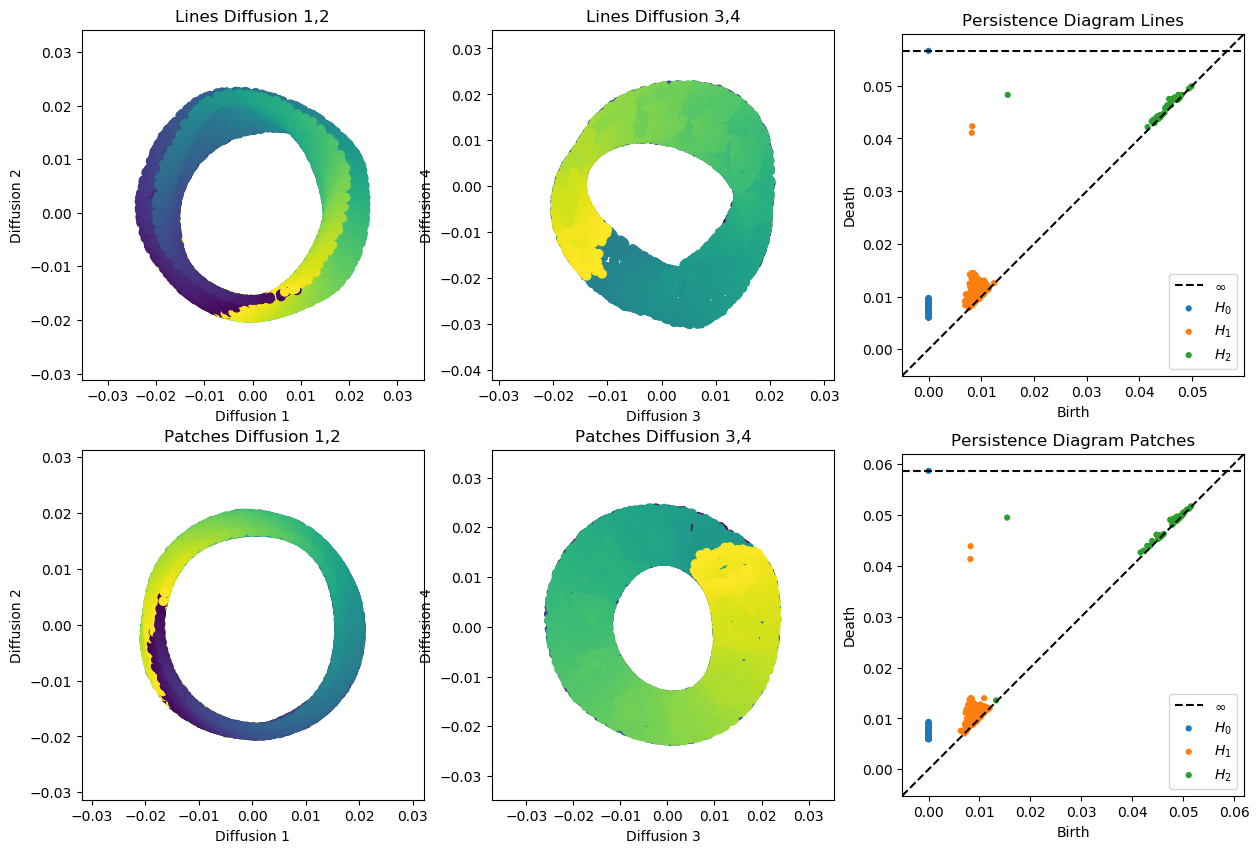

In [4]:
plt.figure(figsize=(15, 10))
labels = ["Lines", "Patches"]
for i in range(2):
    plt.subplot(2, 3, i*3+1)
    plt.scatter(Ys[i][:, 0], Ys[i][:, 1], c=pdes[i].Xs, cmap='viridis')
    plt.xlabel("Diffusion 1")
    plt.ylabel("Diffusion 2")
    plt.title("%s Diffusion 1,2"%labels[i])
    plt.subplot(2, 3, i*3+2)
    plt.scatter(Ys[i][:, 2], Ys[i][:, 3], c=pdes[i].Ts, cmap='viridis')
    plt.xlabel("Diffusion 3")
    plt.ylabel("Diffusion 4")
    plt.title("%s Diffusion 3,4"%labels[i])
    plt.subplot(2, 3, i*3+3)
    plot_dgms(alldgms[i])
    plt.title("Persistence Diagram %s"%labels[i])
plt.savefig("LinesToPatches_DiffusionTDA.svg", bbox_inches='tight')

2
rmse=0.121


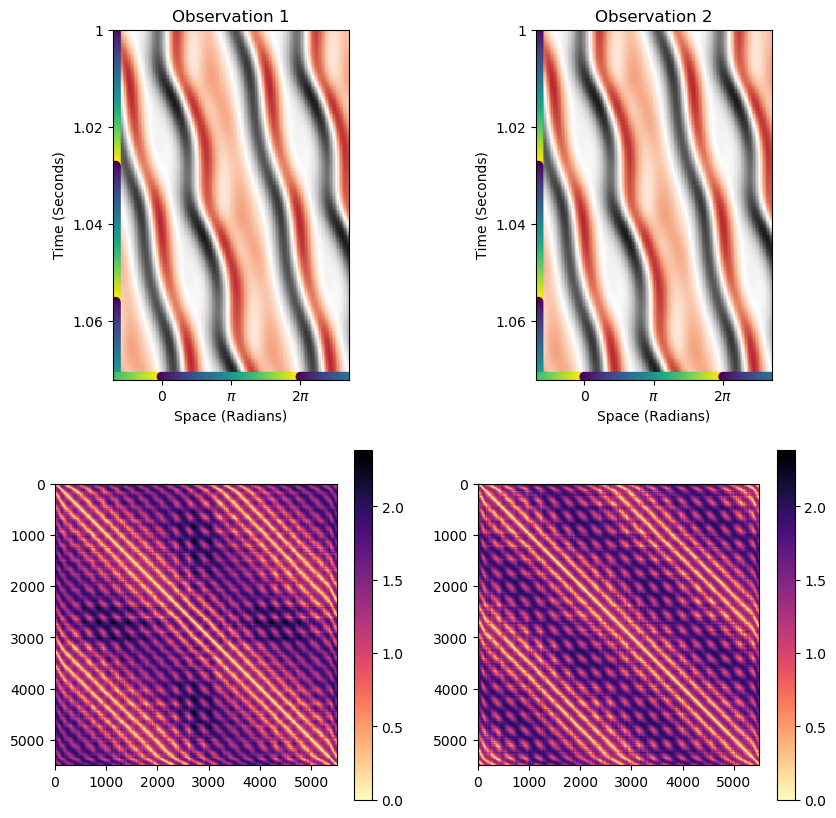

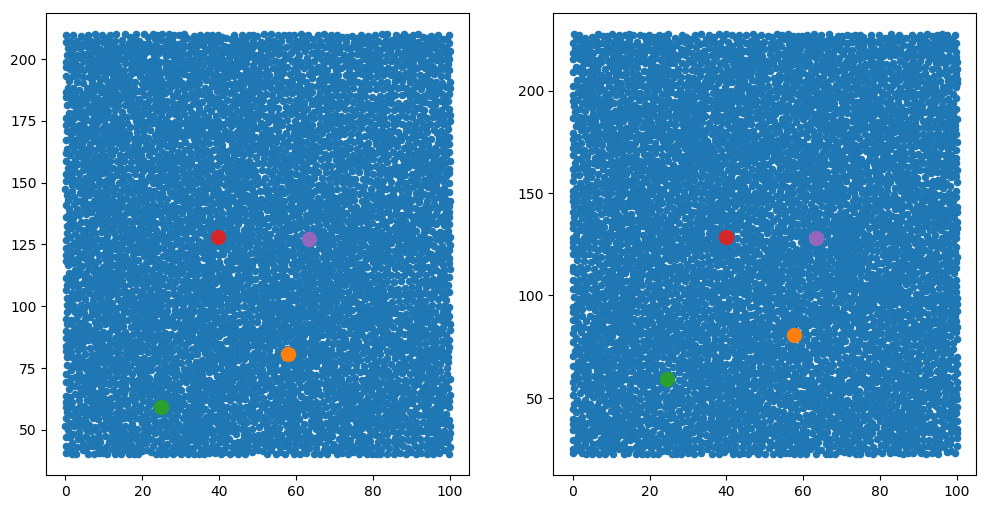

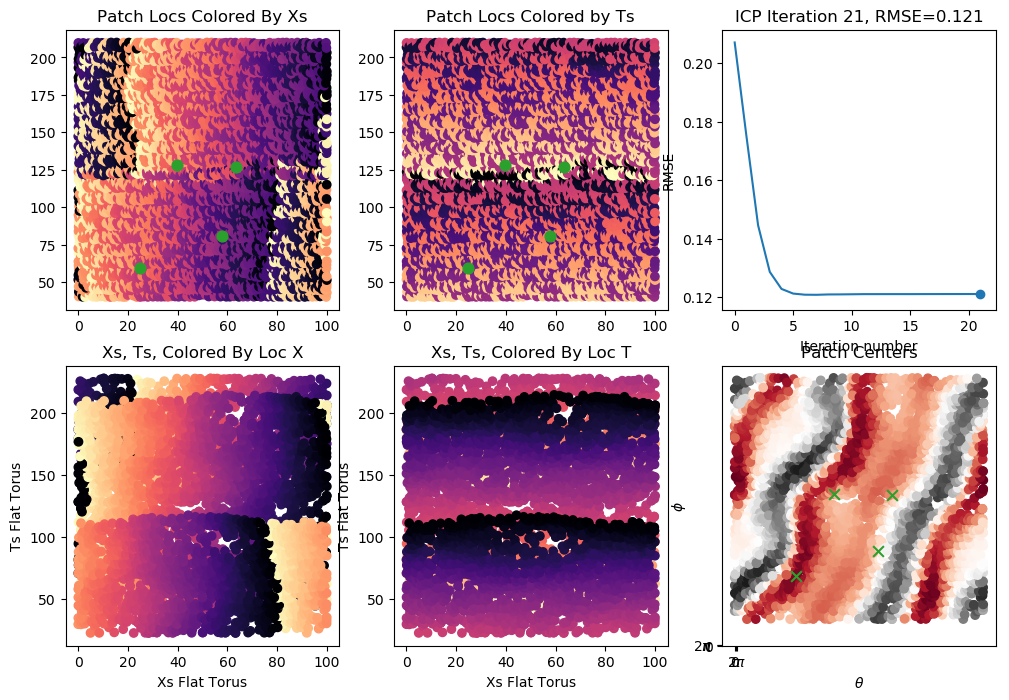

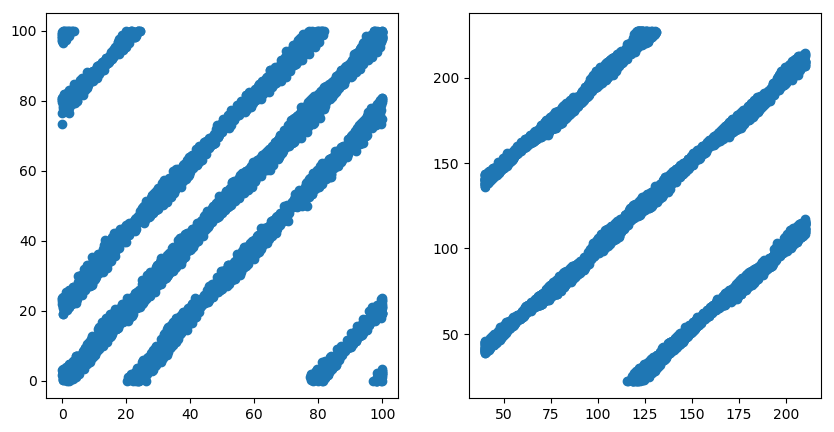

In [8]:
## Align the two patch sets using some correspondences
from SyntheticExamples import FlatTorusIdeal
importlib.reload(ICP)

seed = 2
np.random.seed(seed)
ncorresp = 4
x1 = np.array([pdes[0].Xs, pdes[0].Ts])
x2 = np.array([pdes[1].Xs, pdes[1].Ts])
D = ICP.getCSM(x1, x2)
D = np.argmin(D, 1)
idx = np.random.permutation(np.arange(Ys[0].shape[0]))[0:ncorresp]
corresp = np.zeros((ncorresp, 2), dtype=int)
corresp[:, 0] = idx
corresp[:, 1] = D[idx]
weights = np.ones(Ys[0].shape[0])
weights[idx] = 2000

print(seed)
idxMin = ICP.doICP_PDE2D(pdes[0], Ys[0][:, 0:4], pdes[1], Ys[1][:, 0:4], corresp=corresp, weights=weights, \
                         initial_guesses=1, do_plot=True, MaxIters=200)['idxMin']

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(x1[0, :], x2[0, idxMin[-1]])
plt.subplot(122)
plt.scatter(x1[1, :], x2[1, idxMin[-1]])

In [6]:
pdes[1].f_patch = lambda x: x
pdes[1].completeObservations()

Elapsed time patch sampling: 2.73


(40, 2)
[-48.41987213 -32.74457108]
[50.59903662 24.89614522]
[-19.67285675  30.55808368]
[ 17.70651089 -32.86085753]


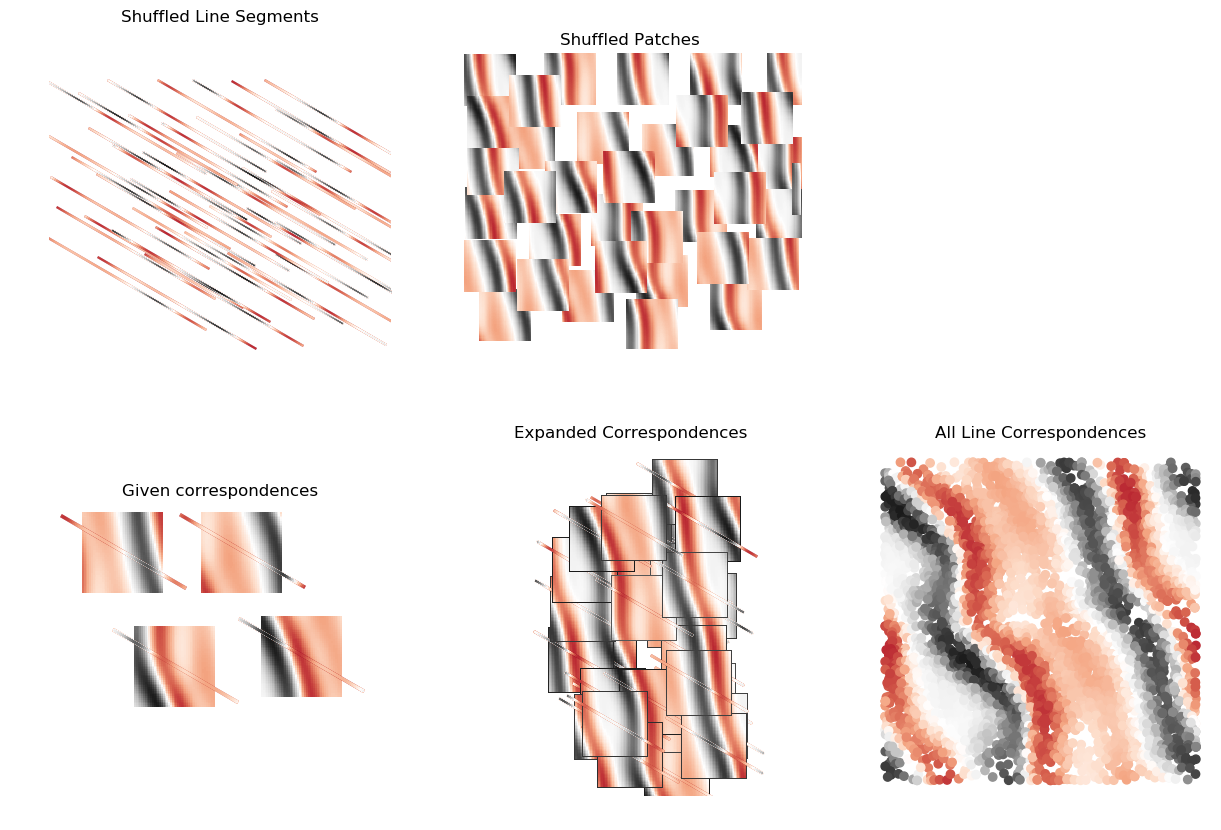

In [19]:
import matplotlib.transforms as mtransforms

plt.figure(figsize=(15, 10))

## Subplot 1: Shuffled line segments on the left, patches on the right

vmax = np.max(np.abs(pdes[0].I))
vmin = -vmax
ax = plt.subplot(231)
N = 40
locs = np.array([pdes[1].Xs, pdes[1].Ts]).T
locs = locs[pdes[1].Ts <= pdes[1].I.shape[1], :]
idxs, _ = getGreedyPerm(locs, N)
locs = locs[idxs, :]
idxs = np.random.permutation(pdes[0].Xs.size)

for i in range(N):
    p = np.reshape(pdes[0].patches[idxs[i], :], pdes[0].pd)
    im = ax.imshow(p, interpolation='none', alpha=1, cmap='RdGy', vmin=vmin, vmax=vmax)
    m = np.eye(3)
    u = locs[i, :]
    m[0:2, 2] = u
    c = np.cos(pdes[0].thetas[i])
    s = np.sin(pdes[0].thetas[i])
    m[0, 0] = c
    m[0, 1] = s
    m[1, 0] = -s
    m[1, 1] = c
    trans = mtransforms.Affine2D()
    trans.set_matrix(m)
    im.set_transform(trans + ax.transData)
plt.xlim([0, 150])
plt.ylim([150, 0])
plt.axis('off')
plt.title("Shuffled Line Segments")


ax = plt.subplot(232)
locs = np.array([pdes[0].Xs, pdes[0].Ts]).T
locs = locs[pdes[1].Ts <= pdes[1].I.shape[1], :]
idxs, _ = getGreedyPerm(locs, N)
locs = locs[idxs, :]
print(locs.shape)
locs -= np.mean(locs, 0)
locs *= 3
idxs = np.random.permutation(pdes[1].Xs.size)
for i in range(N):
    p = np.reshape(pdes[1].patches[idxs[i], :], pdes[1].pd)
    im = ax.imshow(p, interpolation='none', alpha=1, cmap='RdGy', vmin=vmin, vmax=vmax)
    m = np.eye(3)
    u = locs[i, :]
    m[0:2, 2] = u
    trans = mtransforms.Affine2D()
    trans.set_matrix(m)
    im.set_transform(trans + ax.transData)
plt.xlim([-150, 150])
plt.ylim([160, -100])
plt.axis('off')
plt.title("Shuffled Patches")

ax = plt.subplot(234)
locs /= 3
for i in range(corresp.shape[0]):
    print(locs[i, :])
    i1, i2 = corresp[i, :]
    p1 = np.reshape(pdes[0].patches[i1, :], pdes[0].pd)
    p1 = np.concatenate((p1, p1), axis=1)
    p2 = np.reshape(pdes[1].patches[i2, :], pdes[1].pd)
    # Draw square patch first
    im = ax.imshow(p2, interpolation='none', alpha=1, cmap='RdGy', vmin=vmin, vmax=vmax)
    m1 = np.eye(3)
    m1[0:2, 2] = -p2.shape[0]/2
    m = np.eye(3)
    m[0:2, 2] = locs[i, :]
    trans = mtransforms.Affine2D()
    trans.set_matrix(m.dot(m1))
    im.set_transform(trans + ax.transData)
    
    # Now draw corresponding line segment on top of it
    im = ax.imshow(p1, interpolation='none', alpha=1, cmap='RdGy', vmin=vmin, vmax=vmax)
    m1 = np.eye(3)
    m1[1, 2] = -p1.shape[0]/2
    m = np.eye(3)
    m[0:2, 2] = locs[i, :]
    c = np.cos(pdes[0].thetas[i])
    s = np.sin(pdes[0].thetas[i])
    m[0, 0] = c
    m[0, 1] = s
    m[1, 0] = -s
    m[1, 1] = c
    trans = mtransforms.Affine2D()
    trans.set_matrix(m.dot(m1))
    im.set_transform(trans + ax.transData)
plt.xlim([-90, 100])
plt.ylim([70, -60])
plt.axis('off')
plt.title("Given correspondences")

ax = plt.subplot(235)
N = 30
locs = np.array([pdes[1].Xs, pdes[1].Ts]).T
idxs, _ = getGreedyPerm(locs, N)
correspfinal = idxMin[-1]
for i1 in idxs[0:N]:
    i2 = correspfinal[i1]
    p1 = np.reshape(pdes[0].patches[i1, :], pdes[0].pd)
    p1 = np.concatenate((p1, p1), axis=1)
    p2 = np.reshape(pdes[1].patches[i2, :], pdes[1].pd)
    p2t = np.max(p2)*np.ones((p2.shape[0]+2, p2.shape[0]+2))
    p2t[1:-1, 1:-1] = p2
    p2 = p2t
    # Draw square patch first
    im = ax.imshow(p2, interpolation='none', alpha=1, cmap='RdGy', vmin=vmin, vmax=vmax)
    m1 = np.eye(3)
    m1[0:2, 2] = -p2.shape[0]/2
    m = np.eye(3)
    m[0:2, 2] = locs[i2, :]
    trans = mtransforms.Affine2D()
    trans.set_matrix(m.dot(m1))
    im.set_transform(trans + ax.transData)
    
    # Now draw corresponding line segment on top of it
    im = ax.imshow(p1, interpolation='none', alpha=1, cmap='RdGy', vmin=vmin, vmax=vmax)
    m1 = np.eye(3)
    m1[1, 2] = -p1.shape[0]/2
    m = np.eye(3)
    m[0:2, 2] = locs[i2, :]
    c = np.cos(pdes[0].thetas[i])
    s = np.sin(pdes[0].thetas[i])
    m[0, 0] = c
    m[0, 1] = s
    m[1, 0] = -s
    m[1, 1] = c
    trans = mtransforms.Affine2D()
    trans.set_matrix(m.dot(m1))
    im.set_transform(trans + ax.transData)
plt.xlim([-75, 150])
plt.ylim([240, -10])
plt.axis('off')
plt.title("Expanded Correspondences")


plt.subplot(236)
f_interp = pdes[0].getInterpolator()
patch_centers = f_interp(pdes[0].Ts.flatten(), pdes[0].Xs.flatten(), grid=False)
plt.scatter(pdes[1].Xs[correspfinal], pdes[1].Ts[correspfinal], c=patch_centers, cmap='RdGy', vmin=vmin, vmax=vmax)
plt.gca().invert_yaxis()
plt.axis('off')
plt.title("All Line Correspondences")

plt.savefig("LinesToPatchesAligned.svg", bbox_inches='tight')